In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960
DATASET_MAPPING = 'tabular-playground-series-jul-2022:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F33107%2F3943986%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20220729%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20220729T211751Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5ee67912602f78d608264069385d5b352801376e263b43a53ccc7a2afaf993a4396eb9f4d5219b1353a16c3066ef5cea2d4e48353930c581eeb52d768b4049f506c7f736d1d2f7b87afc4452cf782a390c0c2c8eba861debf03a642b027a870a42d8fecd448d4a0b260418970e4ab96722002115b53f4d10c69de2b0a8055cc1ca046cbacd5cf71d8538d03c9f8fefe23c5e5a81e2762b4e5ff8c7bbdacc8a09f69d4cde8a0de7c43336224e3d18b1811fcf5a07ef1722a42b8d5a52d89a3eceb7aaad71e4783cd7c76db5b5fd374c84cedcca5d1f9fc32adba244a15e8662c84269cf85194c1f3901b041edaba36838267b3f6e348e702d646fb3b5ec114995'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

os.makedirs(KAGGLE_INPUT_PATH, 777)
os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
os.makedirs(KAGGLE_INPUT_SYMLINK)
os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


[==================================================] 20595848 bytes downloaded
Unzipping tabular-playground-series-jul-2022
Dataset import complete.


### Introduction

For this challenge, you are given (simulated) manufacturing control data that can be clustered into different control states. Your task is to cluster the data into these control states. You are not given any training data, and you are not told how many possible control states there are. This is a completely unsupervised problem, one you might encounter in a real-world setting.


### import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

import plotly.express as px


### load the data

In [3]:
data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv")
data.head()

id      f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
0   0 -0.389420 -0.912791  0.648951  0.589045 -0.830817  0.733624  2.258560   
1   1 -0.689249 -0.453954  0.654175  0.995248 -1.653020  0.863810 -0.090651   
2   2  0.809079  0.324568 -1.170602 -0.624491  0.105448  0.783948  1.988301   
3   3 -0.500923  0.229049  0.264109  0.231520  0.415012 -1.221269  0.138850   
4   4 -0.671268 -1.039533 -0.270155 -1.830264 -0.290108 -1.852809  0.781898   

   f_07  f_08  ...      f_19      f_20      f_21      f_22      f_23  \
0     2    13  ... -0.478412 -0.757002 -0.763635 -1.090369  1.142641   
1     2     3  ... -0.428791 -0.089908 -1.784204 -0.839474  0.459685   
2     5    11  ... -0.413534 -1.602377  1.190984  3.267116 -0.088322   
3     6     2  ...  0.619283  1.287801  0.532837  1.036631 -2.041828   
4     8     7  ... -1.628830 -0.434948  0.322505  0.284326 -2.438365   

       f_24      f_25      f_26      f_27      f_28  
0 -0.884274  1.137896  1.309073  1.463002  0.813527  
1  1.759412 -0.275422 -0.852168  0.562457 -2.680541  
2 -2.168635 -0.974989  1.335763 -1.110655 -3.630723  
3  1.440490 -1.900191 -0.630771 -0.050641  0.238333  
4  1.473930 -1.044684  1.602686 -0.405263 -1.987263  

[5 rows x 30 columns]

In [4]:
print("\n The shape of the data:", data.shape)
print("\n The information of the dataset", data.info())



 The shape of the data: (98000, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      98000 non-null  int64  
 1   f_00    98000 non-null  float64
 2   f_01    98000 non-null  float64
 3   f_02    98000 non-null  float64
 4   f_03    98000 non-null  float64
 5   f_04    98000 non-null  float64
 6   f_05    98000 non-null  float64
 7   f_06    98000 non-null  float64
 8   f_07    98000 non-null  int64  
 9   f_08    98000 non-null  int64  
 10  f_09    98000 non-null  int64  
 11  f_10    98000 non-null  int64  
 12  f_11    98000 non-null  int64  
 13  f_12    98000 non-null  int64  
 14  f_13    98000 non-null  int64  
 15  f_14    98000 non-null  float64
 16  f_15    98000 non-null  float64
 17  f_16    98000 non-null  float64
 18  f_17    98000 non-null  float64
 19  f_18    98000 non-null  float64
 20  f_19    98000 non-null  float64
 21

In [5]:
data.describe()

id          f_00          f_01          f_02          f_03  \
count  98000.000000  98000.000000  98000.000000  98000.000000  98000.000000   
mean   48999.500000      0.001220      0.005580     -0.001042     -0.000700   
std    28290.307527      1.002801      1.000742      1.001373      1.000422   
min        0.000000     -4.732235     -4.202795     -4.377021     -4.010826   
25%    24499.750000     -0.675226     -0.670985     -0.672779     -0.672540   
50%    48999.500000      0.002022      0.006650     -0.000324     -0.003185   
75%    73499.250000      0.677271      0.677746      0.677086      0.672097   
max    97999.000000      4.490521      4.324974      4.560247      4.399373   

               f_04          f_05          f_06          f_07          f_08  \
count  98000.000000  98000.000000  98000.000000  98000.000000  98000.000000   
mean      -0.003522     -0.001612     -0.003042      5.545918      6.763061   
std        1.003061      1.000532      0.997434      3.691840      4.152348   
min       -4.535903     -4.300767     -4.894525      0.000000      0.000000   
25%       -0.682510     -0.675066     -0.680421      3.000000      4.000000   
50%       -0.003307      0.001024     -0.002053      5.000000      6.000000   
75%        0.677589      0.673344      0.668112      8.000000      9.000000   
max        4.050549      4.710316      3.998595     32.000000     30.000000   

       ...          f_19          f_20          f_21          f_22  \
count  ...  98000.000000  98000.000000  98000.000000  98000.000000   
mean   ...     -0.004513     -0.000515     -0.001670     -0.038752   
std    ...      1.004372      1.002962      0.999703      1.477858   
min    ...     -4.894525     -4.732235     -4.438130     -6.873999   
25%    ...     -0.678773     -0.679777     -0.675147     -1.022964   
50%    ...     -0.000587     -0.000806      0.000819     -0.056687   
75%    ...      0.672149      0.675437      0.676881      0.930158   
max    ...      4.560247      4.399373      4.135419      6.517721   

               f_23          f_24          f_25          f_26          f_27  \
count  98000.000000  98000.000000  98000.000000  98000.000000  98000.000000   
mean      -0.220002      0.166434     -0.064309     -0.062540      0.098472   
std        1.494836      1.543014      1.576086      1.428055      1.305407   
min       -8.234305     -7.792363     -6.593842     -7.375719     -7.335556   
25%       -1.203204     -0.903385     -1.128966     -0.975680     -0.746489   
50%       -0.219046      0.167074     -0.099221     -0.070852      0.082230   
75%        0.764690      1.217432      0.987684      0.843212      0.925306   
max        6.054831      7.527271      7.544731      7.005608      7.205971   

               f_28  
count  98000.000000  
mean      -0.230910  
std        1.528476  
min       -6.954151  
25%       -1.262606  
50%       -0.271319  
75%        0.770516  
max        6.977150  

[8 rows x 30 columns]

In [6]:
data.isnull().sum()

id      0
f_00    0
f_01    0
f_02    0
f_03    0
f_04    0
f_05    0
f_06    0
f_07    0
f_08    0
f_09    0
f_10    0
f_11    0
f_12    0
f_13    0
f_14    0
f_15    0
f_16    0
f_17    0
f_18    0
f_19    0
f_20    0
f_21    0
f_22    0
f_23    0
f_24    0
f_25    0
f_26    0
f_27    0
f_28    0
dtype: int64

In [7]:
# check for any duplicated data types
data.duplicated().sum()

0

In [ ]:
# delete id row
data.drop('id', axis=1, inplace=True)


In [8]:
# data types

data.dtypes

id        int64
f_00    float64
f_01    float64
f_02    float64
f_03    float64
f_04    float64
f_05    float64
f_06    float64
f_07      int64
f_08      int64
f_09      int64
f_10      int64
f_11      int64
f_12      int64
f_13      int64
f_14    float64
f_15    float64
f_16    float64
f_17    float64
f_18    float64
f_19    float64
f_20    float64
f_21    float64
f_22    float64
f_23    float64
f_24    float64
f_25    float64
f_26    float64
f_27    float64
f_28    float64
dtype: object

### EDA

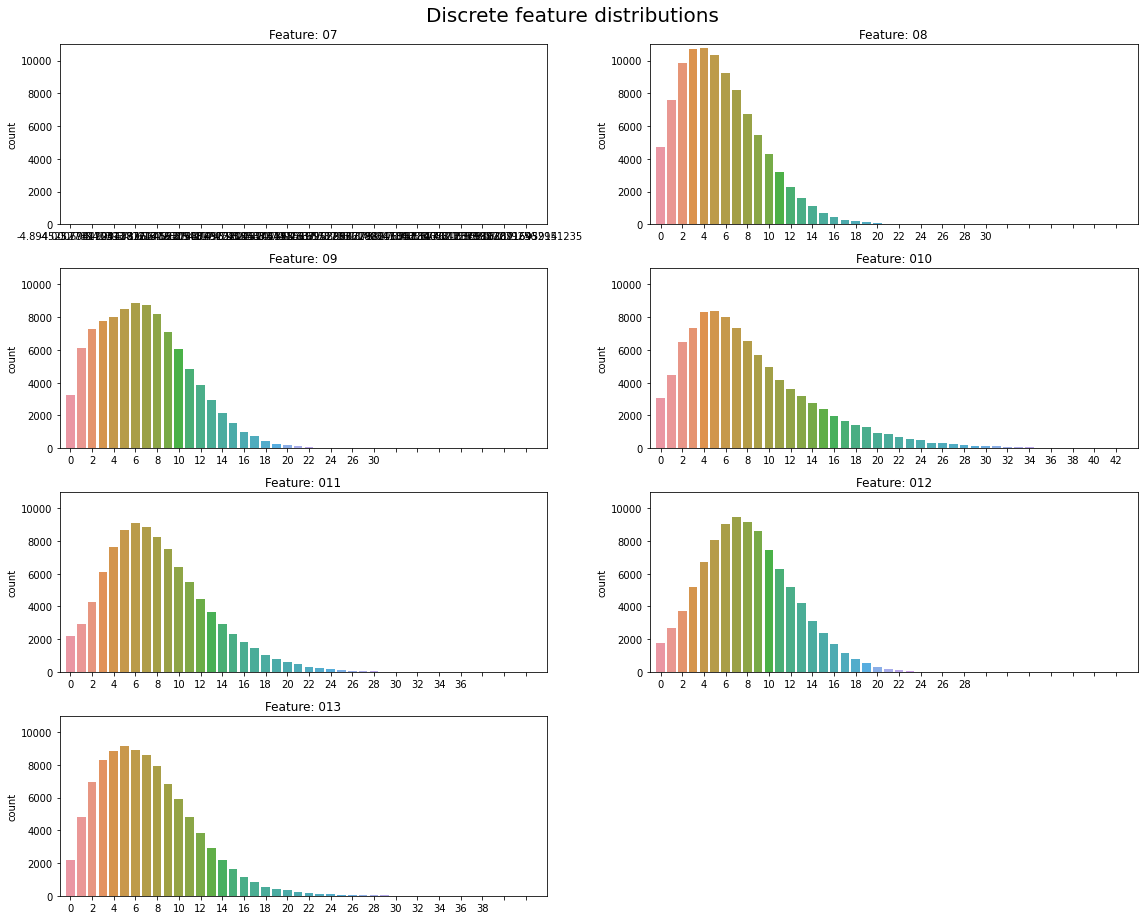

In [9]:
fig = plt.figure(figsize=(16,13))

for i in range(7):
    plt.subplot(4,2,i+1)
    feature_num = i+7
    sns.countplot(x=data.iloc[:, feature_num])
    
    plt.title(f'Feature: 0{feature_num}')
    plt.xlim([-1, 44])
    plt.ylim([0, 11000])
    plt.xticks(np.arange(0,44,2))
    plt.xlabel('')

fig.suptitle('Discrete feature distributions', size=20)
fig.tight_layout() 
plt.show()

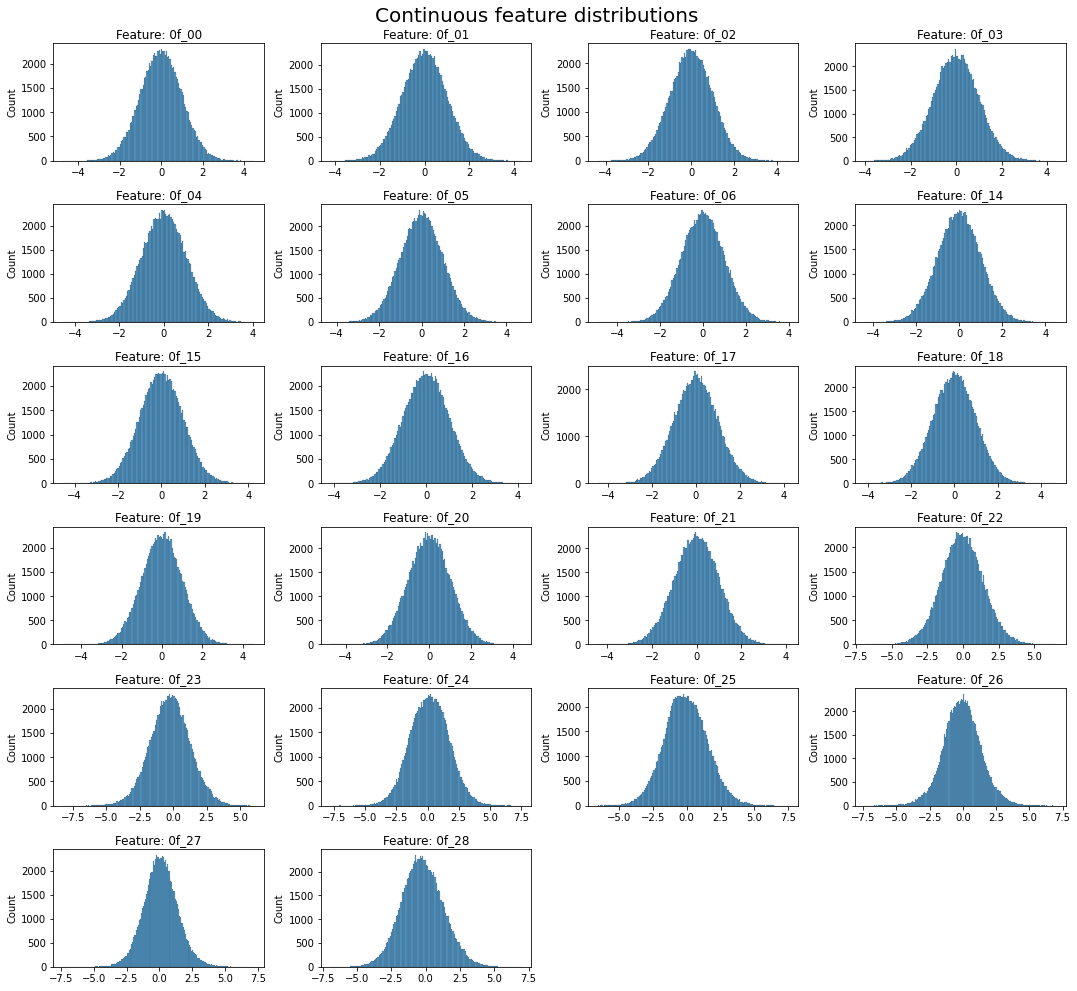

In [10]:
# continuos feature

cont_feats=[f'f_0{i}' for i in range(7)]
cont_feats=cont_feats + [f'f_{i}' for i in range(14,29)]

fig=plt.figure(figsize=(15,14))

for i, f in enumerate(cont_feats):
    plt.subplot(6,4,i+1)
    feature_num = i+7
    sns.histplot(x=data[f])
    
    plt.title(f'Feature: 0{f}')
    plt.xlabel('')

fig.suptitle('Continuous feature distributions', size=20)
fig.tight_layout() 
plt.show()

Text(0.5, 1.0, 'Absolute correlations')

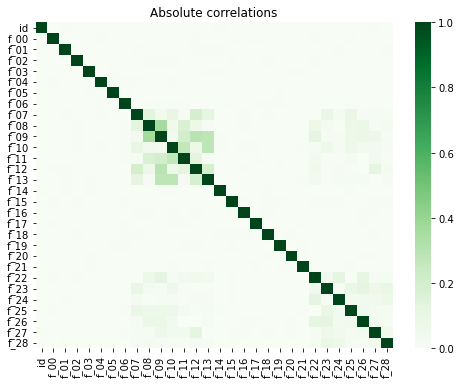

In [11]:
# correlations

plt.figure(figsize=(8,6))
sns.heatmap(data.corr().abs(), cmap='Greens', vmin=0, vmax=1)
plt.title('Absolute correlations')

### Elbow method

Find the number of cluster using elbow method


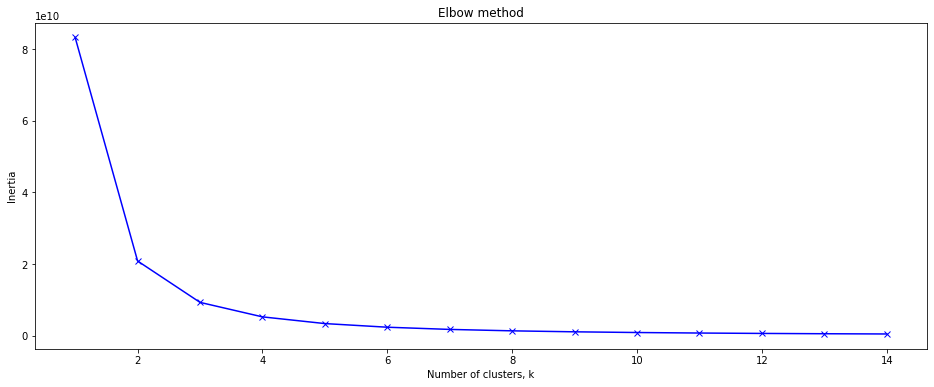

CPU times: user 1min 6s, sys: 25.5 s, total: 1min 32s
Wall time: 24 s


In [12]:
%%time

inertias = []
for k in range(1,15):
    km = KMeans(n_clusters=k)
    km.fit(data.iloc[:10000,:])
    inertias.append(km.inertia_)

# Plot inertias
plt.figure(figsize=(16,6))
plt.plot(range(1,15), inertias, 'bx-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

Lets take cluster value of 7.

### Modelling

In [13]:
scaled_data = pd.DataFrame(StandardScaler().fit_transform(data))
scaled_data.columns = data.columns


In [14]:
#kMeans cluster

# Baseline
model_km = KMeans(n_clusters=7, random_state=0)
preds_km = model_km.fit_predict(scaled_data)

In [15]:
# Gaussian mixture

# Baseline
model_gmm = GaussianMixture(n_components=7, random_state=0)
preds_gmm = model_gmm.fit_predict(scaled_data)

In [16]:
# Baysesian Mixture

# Baseline
model_bgmm = BayesianGaussianMixture(n_components=7, covariance_type='full', max_iter=100, n_init=5, init_params='random', random_state=0)
preds_bgmm = model_bgmm.fit_predict(scaled_data)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


### Visualizations

Text(0.5, 1.0, 'Predicted clusters')

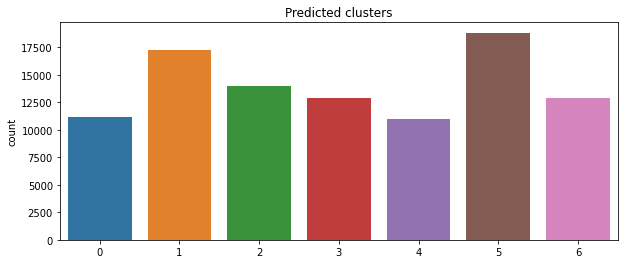

In [17]:
# Countplot
plt.figure(figsize=(10,4))
sns.countplot(x=preds_bgmm)
plt.title('Predicted clusters')

### PCA

In [18]:

# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(scaled_data)

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=preds_bgmm, size=0.1*np.ones(len(scaled_data)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()


In [19]:
sub = pd.read_csv('../input/tabular-playground-series-jul-2022/sample_submission.csv')
sub['Predicted'] = preds_bgmm
sub.to_csv('submission.csv', index=False)